In [15]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
import numpy as np
import random
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from collections import Counter
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay
from sklearn import metrics
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

In [16]:
df = pd.read_csv("Labelled_data/uwv_data_with_labels_pattern_3.csv", encoding_errors="ignore", on_bad_lines='skip', sep=",")
df["TIMESTAMP"] = pd.to_datetime(df["TIMESTAMP"], infer_datetime_format=True)

C:\Users\jveldman\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (12,14,15,16,17) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [17]:
#df_raw = df.sort_values(by=["Label", "SessionID", "TIMESTAMP"], ascending=[False, True, True])
df_raw = df.sort_values(by=["SessionID", "TIMESTAMP"])
df_raw

,Unnamed: 0,CustomerID,AgeCategory,Gender,Office_U,Office_W,SessionID,IPID,TIMESTAMP,VHOST,URL_FILE,PAGE_NAME,REF_URL_category,page_load_error,page_action_detail,tip,service_detail,xps_info,Label
3273278,3273278,1837760,50-65,M,247,247,46,1419591,2015-11-06 08:07:22.780,digid.werk.nl,/werk_nl/werknemer/mijn_werkmap/doorgeven/taken,taken,NaN,0,NaN,NaN,NaN,NaN,normal
5333642,5333642,1837760,50-65,M,247,247,46,1419591,2015-11-06 08:07:40.767,digid.werk.nl,/werk_nl/werknemer/mijn_werkmap/doorgeven/mijn...,mijn_sollicitaties,NaN,0,NaN,NaN,NaN,NaN,normal
3733243,3733243,1837760,50-65,M,247,247,46,1419591,2015-11-06 08:07:51.390,digid.werk.nl,/werk_nl/werknemer/mijn_werkmap/postvak/mijn_d...,mijn_documenten,NaN,0,NaN,NaN,NaN,NaN,normal
5904405,5904405,1837760,50-65,M,247,247,46,1419591,2015-11-06 08:08:06.003,digid.werk.nl,/werk_nl/werknemer/mijn_werkmap/postvak/mijn_b...,mijn_berichten,NaN,0,NaN,NaN,NaN,NaN,normal
5573282,5573282,1837760,50-65,M,247,247,46,1419591,2015-11-06 08:08:19.343,digid.werk.nl,/werk_nl/werknemer/mijn_werkmap/postvak/mijn_b...,mijn_berichten,NaN,0,NaN,NaN,NaN,NaN,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1613546,1613546,2209110,18-29,V,230,230,55314751,505057,2016-02-28 08:17:15.947,www.werk.nl,/werk_nl/werknemer/werkmap,werkmap,UWV,0,NaN,NaN,NaN,NaN,normal
2925569,2925569,2209110,18-29,V,230,230,55314751,505057,2016-02-28 08:18:10.877,digid.werk.nl,/werk_nl/werknemer/mijn_werkmap/doorgeven/taken,taken,NaN,0,NaN,NaN,NaN,NaN,normal
4068602,4068602,2209110,18-29,V,230,230,55314751,505057,2016-02-28 08:18:41.493,digid.werk.nl,/werk_nl/werknemer/mijn_werkmap/doorgeven/taken,taken,NaN,0,NaN,NaN,NaN,NaN,normal
5013440,5013440,2209110,18-29,V,230,230,55314751,505057,2016-02-28 08:19:59.737,digid.werk.nl,/werk_nl/werknemer/mijn_werkmap/doorgeven/taken,taken,NaN,0,NaN,NaN,NaN,NaN,normal


In [18]:
def concat_and_filter(df_raw, file_name, amount_real, amount_anomalies):

    df_gen_anomalies = pd.read_csv(file_name)
    df_gen_anomalies["Label"] = "potential_anomaly"
    df_raw_filtered = df_raw[df_raw["SessionID"].isin(df_raw["SessionID"].unique()[:amount_real])]
    df_gen_anomalies_filtered = df_gen_anomalies[df_gen_anomalies["SessionID"].isin(df_gen_anomalies["SessionID"].unique()[:amount_anomalies])]

    df = pd.concat([df_raw_filtered, df_gen_anomalies_filtered])
    return df

def df_one_hot_encoder(df):
    #creating instance of one-hot-encoder
    encoder = OneHotEncoder()
    
    #perform one-hot encoding on 'team' column 
    encoder_df = pd.DataFrame(encoder.fit_transform(df[['URL_FILE']]).toarray(), index=df.index)
    encoder_df.columns = encoder.get_feature_names(['URL_FILE'])

    #merge one-hot encoded columns back with original DataFrame
    final_df = df.join(encoder_df)
    return final_df

def calculating_duration(df):
    #Calculating the duration of an activity by using the end time. Duration returned in minutes
    df["End_time"] = df.groupby("SessionID")["TIMESTAMP"].shift(periods=-1)
    df["Duration"] = (df["End_time"] - df["TIMESTAMP"]) / pd.offsets.Minute(1)
    return df

def make_df_for_isolation_forest(df):
    #Counting each activity in every session
    df_sum = df.groupby("SessionID").sum()
    df_sum["Label"] = df.groupby("SessionID")["Label"].max()
    return df_sum

In [19]:
#Filter to get df with only real anomalies
amount_for_filtering_real_anomalies = 0
df_only_real_anomalies = df_raw[df_raw["Label"] == "potential_anomaly"]

#Make the data ready for training
df_only_anomaly_selection = df_only_real_anomalies[["SessionID", "URL_FILE", "Label"]]
one_hot_encoded_df_only_anomalies = df_one_hot_encoder(df_only_anomaly_selection)
df_only_anomalies_for_training = make_df_for_isolation_forest(one_hot_encoded_df_only_anomalies)

df_only_anomalies_for_train_set = df_only_anomalies_for_training[:10]
df_only_anomalies_for_test_set = df_only_anomalies_for_training[10:]

In [20]:
#Select amount of sessions used in the dataframe
var_1_amount_real = 50000
var_1_amount_generated = 0
df_real = concat_and_filter(df_raw, "generated_data/Pattern_2/generated_anomalies_plus_0_5_2k.csv", amount_real = var_1_amount_real, amount_anomalies = var_1_amount_generated)

#Filter only the normal instances. 
df_real = df_real[df_real["Label"] == "normal"]

#df_real = pd.concat([df_real, df_only_real_anomalies_filtered])

#Make the data ready for training
df_real_selection = df_real[["SessionID", "URL_FILE", "Label"]]
one_hot_encoded_df_real = df_one_hot_encoder(df_real_selection)
df_real_for_training = make_df_for_isolation_forest(one_hot_encoded_df_real)

In [21]:
#Make train test split
X = df_real_for_training.drop(columns=["Label"])
y = df_real_for_training["Label"]

X_train_temp, X_test_temp, y_train_temp, y_test_temp = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
#Add 10 anomalies back to the training data to make it more realistic.
X_train = pd.concat([X_train_temp, df_only_anomalies_for_train_set.drop(columns=["Label"])]).fillna(0)
y_train = pd.concat([y_train_temp, df_only_anomalies_for_train_set["Label"]])

In [24]:
X_test = pd.concat([X_test_temp, df_only_anomalies_for_test_set.drop(columns=["Label"])]).fillna(0)
y_test = pd.concat([y_test_temp, df_only_anomalies_for_test_set["Label"]])

### 0 = normal, 1 = anomaly

generated_data/Pattern_3/generated_anomalies_plus_0_2k.csv 10
0.5686134002673852

generated_data/Pattern_3/generated_anomalies_plus_0_2k.csv 20
0.5773853300919465

generated_data/Pattern_3/generated_anomalies_plus_0_2k.csv 50
0.5845952215874018

generated_data/Pattern_3/generated_anomalies_plus_0_2k.csv 65
0.5845952215874018

generated_data/Pattern_3/generated_anomalies_plus_0_2k.csv 100
0.6209948541522223

generated_data/Pattern_3/generated_anomalies_plus_0_2k.csv 200
0.6925322310277945

generated_data/Pattern_3/generated_anomalies_plus_0_2k.csv 300
0.7522736514456059

generated_data/Pattern_3/generated_anomalies_plus_0_2k.csv 400
0.7913971605685884

generated_data/Pattern_3/generated_anomalies_plus_0_2k.csv 500
0.8232107281711031

generated_data/Pattern_3/generated_anomalies_plus_0_2k.csv 600
0.8596603857484298

generated_data/Pattern_3/generated_anomalies_plus_0_2k.csv 700
0.8870379634261576

generated_data/Pattern_3/generated_anomalies_plus_0_2k.csv 800
0.8969217064672688

generate

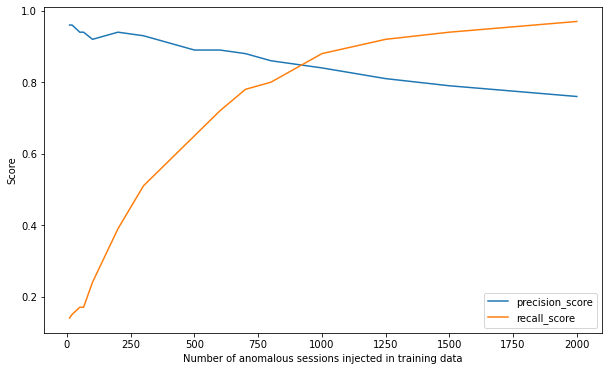

generated_data/Pattern_3/generated_anomalies_plus_0_2_3k.csv 10
0.5715373768755724

generated_data/Pattern_3/generated_anomalies_plus_0_2_3k.csv 20
0.5700753885714787

generated_data/Pattern_3/generated_anomalies_plus_0_2_3k.csv 50
0.5818213200167335

generated_data/Pattern_3/generated_anomalies_plus_0_2_3k.csv 65
0.5993651796658562

generated_data/Pattern_3/generated_anomalies_plus_0_2_3k.csv 100
0.6066751211863243

generated_data/Pattern_3/generated_anomalies_plus_0_2_3k.csv 200
0.6183210026065664

generated_data/Pattern_3/generated_anomalies_plus_0_2_3k.csv 300
0.6269428573936092

generated_data/Pattern_3/generated_anomalies_plus_0_2_3k.csv 400
0.6340526988640519

generated_data/Pattern_3/generated_anomalies_plus_0_2_3k.csv 500
0.6399006520804262

generated_data/Pattern_3/generated_anomalies_plus_0_2_3k.csv 600
0.6442365919802007

generated_data/Pattern_3/generated_anomalies_plus_0_2_3k.csv 700
0.6485725318799751

generated_data/Pattern_3/generated_anomalies_plus_0_2_3k.csv 800
0.65

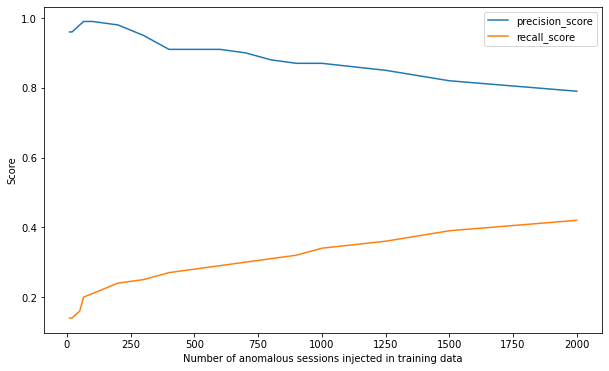

generated_data/Pattern_3/generated_anomalies_plus_1_3k.csv 10
0.5598414704428238

generated_data/Pattern_3/generated_anomalies_plus_1_3k.csv 20
0.562765447051011

generated_data/Pattern_3/generated_anomalies_plus_1_3k.csv 50
0.5583794821387301

generated_data/Pattern_3/generated_anomalies_plus_1_3k.csv 65
0.5686134002673852

generated_data/Pattern_3/generated_anomalies_plus_1_3k.csv 100
0.5876692732331079

generated_data/Pattern_3/generated_anomalies_plus_1_3k.csv 200
0.5963411530326567

generated_data/Pattern_3/generated_anomalies_plus_1_3k.csv 300
0.6064750211362991

generated_data/Pattern_3/generated_anomalies_plus_1_3k.csv 400
0.6136348876192482

generated_data/Pattern_3/generated_anomalies_plus_1_3k.csv 500
0.6122729493401671

generated_data/Pattern_3/generated_anomalies_plus_1_3k.csv 600
0.6137349376442607

generated_data/Pattern_3/generated_anomalies_plus_1_3k.csv 700
0.6136849126317545

generated_data/Pattern_3/generated_anomalies_plus_1_3k.csv 800
0.6165088392149292

generated

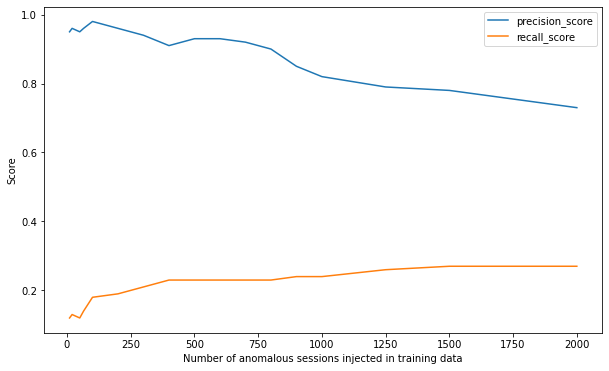

generated_data/Pattern_3/generated_anomalies_plus_5_2k.csv 10
0.5656894236591979

generated_data/Pattern_3/generated_anomalies_plus_5_2k.csv 20
0.562765447051011

generated_data/Pattern_3/generated_anomalies_plus_5_2k.csv 50
0.5657394486717043

generated_data/Pattern_3/generated_anomalies_plus_5_2k.csv 65
0.5700253635589725

generated_data/Pattern_3/generated_anomalies_plus_5_2k.csv 100
0.577285280066934

generated_data/Pattern_3/generated_anomalies_plus_5_2k.csv 200
0.5889811864996826

generated_data/Pattern_3/generated_anomalies_plus_5_2k.csv 300
0.5947791147035506

generated_data/Pattern_3/generated_anomalies_plus_5_2k.csv 400
0.5918051130828571

generated_data/Pattern_3/generated_anomalies_plus_5_2k.csv 500
0.5960410029576191

generated_data/Pattern_3/generated_anomalies_plus_5_2k.csv 600
0.5987648795157813

generated_data/Pattern_3/generated_anomalies_plus_5_2k.csv 700
0.5942788645784881

generated_data/Pattern_3/generated_anomalies_plus_5_2k.csv 800
0.5956908278700754

generated_

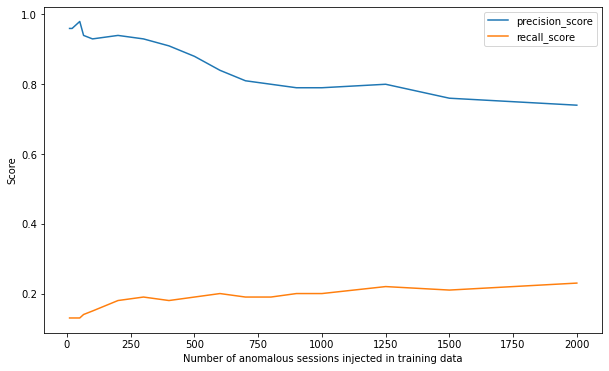

generated_data/Pattern_3/generated_anomalies_plus_25_2k.csv 10
0.5555055305430494

generated_data/Pattern_3/generated_anomalies_plus_25_2k.csv 20
0.5526315789473684

generated_data/Pattern_3/generated_anomalies_plus_25_2k.csv 50
0.5584295071512364

generated_data/Pattern_3/generated_anomalies_plus_25_2k.csv 65
0.5642774603676108

generated_data/Pattern_3/generated_anomalies_plus_25_2k.csv 100
0.5598414704428238

generated_data/Pattern_3/generated_anomalies_plus_25_2k.csv 200
0.5627154220385047

generated_data/Pattern_3/generated_anomalies_plus_25_2k.csv 300
0.5597914454303176

generated_data/Pattern_3/generated_anomalies_plus_25_2k.csv 400
0.5627154220385047

generated_data/Pattern_3/generated_anomalies_plus_25_2k.csv 500
0.5699253135339599

generated_data/Pattern_3/generated_anomalies_plus_25_2k.csv 600
0.5743112784462407

generated_data/Pattern_3/generated_anomalies_plus_25_2k.csv 700
0.5772352550544277

generated_data/Pattern_3/generated_anomalies_plus_25_2k.csv 800
0.57577326675033

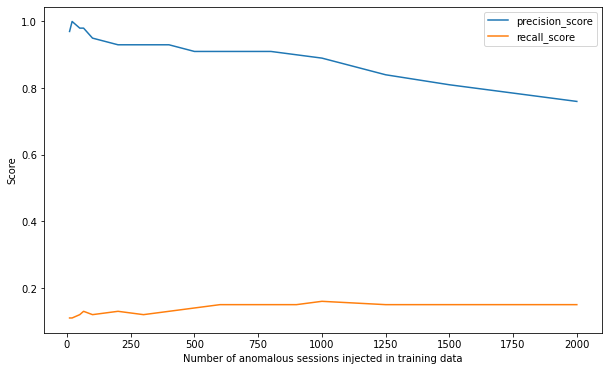

In [10]:
list_urls = [ 'generated_data/Pattern_1/generated_anomalies_plus_0_10k.csv',
             "generated_data/Pattern_1/generated_anomalies_plus_0_2_2k.csv", 
             'generated_data/Pattern_1/generated_anomalies_plus_5_5k.csv',             
            'generated_data/Pattern_1/generated_anomalies_plus_1_3k.csv', 
             'generated_data/Pattern_1/generated_anomalies_plus_25_10k.csv']

list_urls_2 = ['generated_data/Pattern_2/generated_anomalies_plus_0_2k.csv',
            'generated_data/Pattern_2/generated_anomalies_plus_0_2_2k.csv',
             'generated_data/Pattern_2/generated_anomalies_plus_1_2k.csv',
             'generated_data/Pattern_2/generated_anomalies_plus_5_2k.csv',
             'generated_data/Pattern_2/generated_anomalies_plus_25_2k.csv']

list_urls_3 = ['generated_data/Pattern_3/generated_anomalies_plus_0_2k.csv',
             'generated_data/Pattern_3/generated_anomalies_plus_0_2_3k.csv',
             'generated_data/Pattern_3/generated_anomalies_plus_1_3k.csv',
             'generated_data/Pattern_3/generated_anomalies_plus_5_2k.csv',
             'generated_data/Pattern_3/generated_anomalies_plus_25_2k.csv']
             

auc_score_dicts = {}
dict_prec_and_rec_list = {}

amount_anomalies_list_total = []
precision_score_list_total = []
recall_score_list_total = []

for url in list_urls_3:
    amount_anomalies_list = []
    precision_score_list = []
    recall_score_list = []

    for var_2_amount_generated in [10, 20, 50, 65, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1250, 1500, 2000]:
    #[10, 100, 500, 1000, 2000]:
    #for var_2_amount_generated in [2000, 2500, 3000, 4000, 5000, 9999]:

        #Select amount of sessions used in the dataframe
        var_2_amount_real = 0

        df_generated = concat_and_filter(df_raw, url, amount_real = var_2_amount_real, amount_anomalies=var_2_amount_generated)
        #Make data ready for training
        df_generated_selection = df_generated[["SessionID", "URL_FILE", "Label"]]
        one_hot_encoded_df_generated = df_one_hot_encoder(df_generated_selection)
        df_generated_for_training = make_df_for_isolation_forest(one_hot_encoded_df_generated)

        #Add the generated anomalies to the training dataset
        X_train_extra = pd.concat([X_train, df_generated_for_training.drop(columns=["Label"])]).fillna(0)
        y_train_extra = pd.concat([y_train, df_generated_for_training["Label"]])

        #transform y values to binary class
        Le = LabelEncoder()
        Le.fit(y_train_extra)
        y_train_transformed = Le.transform(y_train)
        y_test_transformed = Le.transform(y_test)
        y_train_extra_transformed = Le.transform(y_train_extra)

        #Make sure that both dataframes have the same columns
        for column_name in X_train_extra.columns:
            if column_name not in X_test.columns:
                X_test[column_name] = 0

        #Make sure that both dataframes have the same columns
        for column_name in X_test.columns:
            if column_name not in X_train_extra.columns:
                X_test.drop(columns=[column_name], inplace=True)
        
        #clf_extra = tree.DecisionTreeClassifier().fit(X_train_extra, y_train_extra_transformed)
        clf_extra = LogisticRegression(random_state=0, max_iter=1000).fit(X_train_extra, y_train_extra_transformed)
        #y_train_predict = clf_extra.predict(X_train_extra)
        y_test_predict = clf_extra.predict(X_test)
        
        #AUC predict
        fpr, tpr, thresholds = metrics.roc_curve(y_test_transformed, y_test_predict)
        print(url, var_2_amount_generated)
        print(metrics.auc(fpr, tpr))
        print()
        auc_score_dicts[(url, var_2_amount_generated)] = metrics.auc(fpr, tpr)
        

        
        precision_score = [i for i in classification_report(y_test_transformed, y_test_predict).split(" ") if len(i) > 2][8]
        recall_score = [i for i in classification_report(y_test_transformed, y_test_predict).split(" ") if len(i) > 2][9]

        amount_anomalies_list.append(var_2_amount_generated)
        precision_score_list.append(precision_score)
        recall_score_list.append(recall_score)
    
    
    amount_anomalies_list = [int(i) for i in amount_anomalies_list]
    precision_score_list = [float(i) for i in precision_score_list]
    recall_score_list = [float(i) for i in recall_score_list]
    print(amount_anomalies_list, precision_score_list, recall_score_list)
    
    string_recall = "recall_" + str(url)
    string_precision = "precision_" + str(url)
    dict_prec_and_rec_list[string_recall] = recall_score_list
    dict_prec_and_rec_list[string_precision] = precision_score_list
    
    plt.figure(figsize=(10, 6))
    plt.plot(amount_anomalies_list, precision_score_list, label = "precision_score")
    plt.plot(amount_anomalies_list, recall_score_list, label = "recall_score")
    plt.xlabel("Number of anomalous sessions injected in training data")
    plt.ylabel("Score")
    save_string = "prec_rec_scores/" + str(url.split(".")[0].split("/")[1] + url.split(".")[0].split("/")[2]) + ".png"    
    plt.legend()
    plt.savefig(save_string)
    plt.show()
    


## AUC plots

In [ ]:
fig = plt.figure(figsize = (12, 8))

deviation_rate_list = [0, 0.2, 1, 5, 25]
deviation_rate_value = 0
for key in list_urls_3:
    y_values = [auc_score_dicts[(key, getal)] for getal in [10, 100, 500, 1000, 2000]]
        -
    print(key.split("_"))
    print(y_values)
    deviation_rate_string = "Deviation rate = " + str(deviation_rate_list[deviation_rate_value])
    deviation_rate_value += 1
    
    plt.plot([10, 100, 500, 1000, 2000], 
             y_values, 
             label=deviation_rate_string )

plt.margins(x=0.1)
plt.margins(y=0.1)


# axis labels
plt.xlabel('Number of injected anomalies')
plt.ylabel('AUC scores')
# show the legend
plt.legend()
plt.savefig("AUC plots/AUC_plot advanced repetition pattern.png")
plt.show()

## Prec recall plots

In [ ]:
dict_prec_and_rec_list

In [11]:
dict_for_changes = dict_prec_and_rec_list.copy()

In [12]:
for i in dict_for_changes.keys():
    try: 
        if i.split("_")[0] == "recall":
            #dict_for_changes[i].remove(0)
            #dict_for_changes[i].remove(1)

            dict_for_changes[i] = [0] + dict_for_changes[i] + [1]

        else:
            #dict_for_changes[i].remove(0)
            #dict_for_changes[i].remove(1)

            dict_for_changes[i] = [1] + dict_for_changes[i] + [0]
    except:
        continue

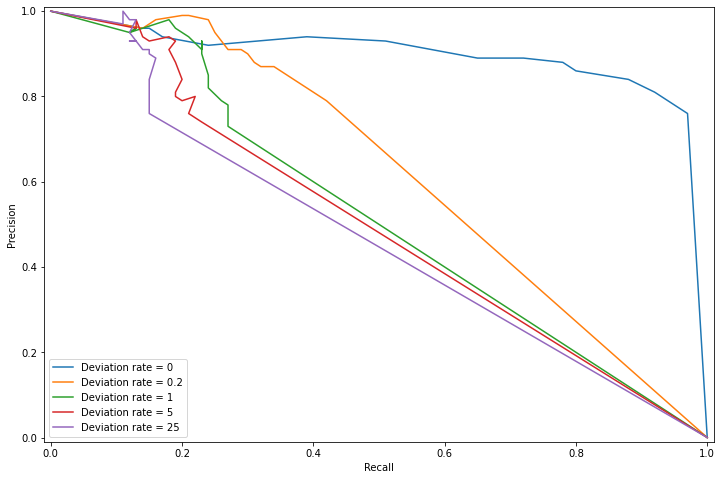

In [14]:
fig = plt.figure(figsize = (12, 8))


plt.plot(dict_for_changes["recall_generated_data/Pattern_3/generated_anomalies_plus_0_2k.csv"], 
         dict_for_changes["precision_generated_data/Pattern_3/generated_anomalies_plus_0_2k.csv"], 
         label='Deviation rate = 0')

plt.plot(dict_for_changes["recall_generated_data/Pattern_3/generated_anomalies_plus_0_2_3k.csv"], 
         dict_for_changes["precision_generated_data/Pattern_3/generated_anomalies_plus_0_2_3k.csv"], 
         label='Deviation rate = 0.2')

plt.plot(dict_for_changes["recall_generated_data/Pattern_3/generated_anomalies_plus_1_3k.csv"], 
         dict_for_changes["precision_generated_data/Pattern_3/generated_anomalies_plus_1_3k.csv"], 
         label='Deviation rate = 1')

plt.plot(dict_for_changes["recall_generated_data/Pattern_3/generated_anomalies_plus_5_2k.csv"], 
         dict_for_changes["precision_generated_data/Pattern_3/generated_anomalies_plus_5_2k.csv"], 
         label='Deviation rate = 5')

plt.plot(dict_for_changes["recall_generated_data/Pattern_3/generated_anomalies_plus_25_2k.csv"], 
         dict_for_changes["precision_generated_data/Pattern_3/generated_anomalies_plus_25_2k.csv"], 
         label='Deviation rate = 25')

plt.margins(x=0.01)
plt.margins(y=0.01)


# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
plt.savefig("precision_recall_curve_advanced_repetition_pattern.png")
plt.show()